# Coronavirus X-ray Classifier - Modelling

Name: Kyle Cohick   
Class: CSCI 349: Intro to Data Mining   
Semester: 2020SP   
Instructor: Brian King 

In [15]:
from IPython.display import display
import itertools as it
from keras import optimizers
from keras.layers import Conv2D, Dropout, Flatten, MaxPooling2D
from keras.layers.core import Activation, Dense
from keras.models import Sequential
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Data Import
All the data was prepped in my folders in the DataPrep_EDA.ipynb file, so the code below is just to load the data and make it available for modelling.

In [2]:
# creating instances of ImageDataGenerator for the training and validation imagesets
train_imageDataGenerator = image.ImageDataGenerator(rescale = 1./255, # to what size it's being rescaled
                                                    shear_range = 0.2, # shear intensity
                                                    zoom_range = 0.2) # how much to zoom in

val_imageDataGenerator = image.ImageDataGenerator(rescale=1./255)

# reshaping the test and validation images
train_generator = train_imageDataGenerator.flow_from_directory(
    'data/prepped_datasets/training', # directory containing the images
    target_size = (224,224), # the dimensions to which all images found will be resized
    batch_size = 32, # size of batches
    class_mode = 'binary', # determines type of label array returned, since there are two classes, binary is fine
    shuffle=True) # shuffles order images are interred
validation_generator = val_imageDataGenerator.flow_from_directory(
    'data/prepped_datasets/val',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary', 
    shuffle=True)

# sources:
# https://keras.io/preprocessing/image/
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://towardsdatascience.com/detecting-covid-19-using-deep-learning-262956b6f981

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


## 3-Layer Model
This model will be built and tested against the hyperparamters in a 3-layer Sequential Keras model.

In [24]:
# model creation
model3 = Sequential()

# input layer
model3.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 1
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 2
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Sources:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# https://towardsdatascience.com/detecting-covid-19-using-deep-learning-262956b6f981

### Initial Training

In [25]:
model3_result = model3.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1
)

Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 0.9773 - accuracy: 0.5216 - val_loss: 0.6496 - val_accuracy: 0.8500
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 0.6350 - accuracy: 0.6164 - val_loss: 0.4130 - val_accuracy: 0.8833
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 0.5188 - accuracy: 0.7500 - val_loss: 0.3499 - val_accuracy: 0.8833
Epoch 4/10
8/8 [==============================] - 11s 1s/step - loss: 0.5521 - accuracy: 0.7931 - val_loss: 0.4045 - val_accuracy: 0.9167
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.3477 - accuracy: 0.8534 - val_loss: 0.1694 - val_accuracy: 0.9500
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.5728 - accuracy: 0.8491 - val_loss: 0.2964 - val_accuracy: 0.8667
Epoch 7/10
8/8 [==============================] - 12s 1s/step - loss: 0.3410 - accuracy: 0.8879 - val_loss: 0.0993 - val_accuracy: 0.9667
Epoch 8/10
8/8 [==================

## Evaluation

In [7]:
pd.DataFrame(model3_result.history)

,val_loss,val_accuracy,loss,accuracy
0,0.705152,0.500000,0.746789,0.556035
1,0.390296,0.833333,0.544702,0.728448
2,0.274096,0.883333,0.516743,0.780172
3,0.162740,0.950000,0.508329,0.806035
4,0.514610,0.850000,0.218445,0.918103
5,0.793025,0.783333,0.433329,0.844828
6,0.095991,0.966667,0.437889,0.896552
7,0.022465,0.983333,0.166192,0.948276
8,0.228743,0.966667,0.104254,0.965517
9,0.087123,0.966667,0.331765,0.896552


In [28]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
y_true = []
y_pred = []

# get predictions for all in the Normal validation set
for file in os.listdir("./data/prepped_datasets/val/Normal/"):
    img=image.load_img("./data/prepped_datasets/val/Normal/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    pred=model3.predict_classes(img)
    y_pred.append(pred[0,0])
    y_true.append(1)
    
for file in os.listdir("./data/prepped_datasets/val/Covid/"):
    img=image.load_img("./data/prepped_datasets/val/Covid/" + file,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=model3.predict_classes(img)
    y_pred.append(pred[0,0])
    y_true.append(0)
    
y_true=np.array(y_true)
y_pred=np.array(y_pred)

In [53]:
print(confusion_matrix(y_true, y_pred))

[[28  2]
 [ 4 26]]


In [54]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       0.93      0.87      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



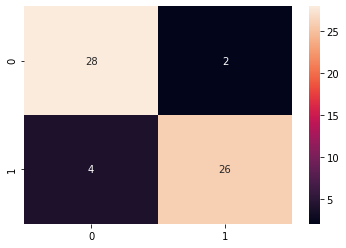

In [55]:
# {'Covid': 0, 'Normal': 1}
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

This model, albeit the simplest in terms of complexity seems to perform the best with the highest f1-scores, a higher val_accuracy, but with a slightly higher loss rate. This will be the model that I perform hyperparameter tuning on.

## 5-Layer Model

In [43]:
# model creation
model5 = Sequential()

# input layer
model5.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 1
model5.add(Conv2D(32, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 2
model5.add(Conv2D(64, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 3
model5.add(Conv2D(128, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 4
model5.add(Conv2D(64, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model5.add(Dense(64))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1))
model5.add(Activation('sigmoid'))

model5.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [44]:
model5_result = model5.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1
)

Epoch 1/10
8/8 [==============================] - 12s 2s/step - loss: 0.7332 - accuracy: 0.4957 - val_loss: 0.6827 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 12s 1s/step - loss: 0.6805 - accuracy: 0.5733 - val_loss: 0.5779 - val_accuracy: 0.8333
Epoch 3/10
8/8 [==============================] - 12s 1s/step - loss: 0.5999 - accuracy: 0.6595 - val_loss: 0.3941 - val_accuracy: 0.9333
Epoch 4/10
8/8 [==============================] - 12s 1s/step - loss: 0.4060 - accuracy: 0.8103 - val_loss: 0.2092 - val_accuracy: 0.9500
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.4275 - accuracy: 0.8491 - val_loss: 1.2962 - val_accuracy: 0.5500
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.4458 - accuracy: 0.8276 - val_loss: 0.2496 - val_accuracy: 0.9333
Epoch 7/10
8/8 [==============================] - 11s 1s/step - loss: 0.2111 - accuracy: 0.9095 - val_loss: 0.3127 - val_accuracy: 0.9167
Epoch 8/10
8/8 [==================

In [45]:
pd.DataFrame(model5_result.history)

,val_loss,val_accuracy,loss,accuracy
0,0.682701,0.500000,0.743064,0.495690
1,0.577937,0.833333,0.679885,0.573276
2,0.394103,0.933333,0.597993,0.659483
3,0.209245,0.950000,0.412134,0.810345
4,1.296224,0.550000,0.427489,0.849138
5,0.249650,0.933333,0.421051,0.827586
6,0.312706,0.916667,0.214564,0.909483
7,0.161442,0.933333,0.470782,0.814655
8,0.144557,0.916667,0.223868,0.931035
9,0.138656,0.866667,0.154931,0.939655


In [48]:
y_pred = []

# get predictions for all in the Normal validation set
for file in os.listdir("./data/prepped_datasets/val/Normal/"):
    img=image.load_img("./data/prepped_datasets/val/Normal/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    pred=model5.predict_classes(img)
    y_pred.append(pred[0,0])
    
for file in os.listdir("./data/prepped_datasets/val/Covid/"):
    img=image.load_img("./data/prepped_datasets/val/Covid/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=model5.predict_classes(img)
    y_pred.append(pred[0,0])
    
y_pred=np.array(y_pred)

In [49]:
print(confusion_matrix(y_true, y_pred))

[[30  0]
 [12 18]]


In [50]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        30
           1       1.00      0.60      0.75        30

    accuracy                           0.80        60
   macro avg       0.86      0.80      0.79        60
weighted avg       0.86      0.80      0.79        60



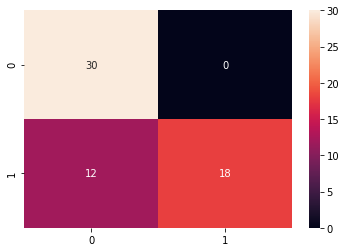

In [51]:
# {'Covid': 0, 'Normal': 1}
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

The findings here looked promising as the accuracy was high, but upon the test data, the scores were extremely low. The one positive thing that came out of this evaluation is the propensity for lack of false positives.

## 6-Layer Model

In [20]:
# model creation
model6 = Sequential()

# input layer
model6.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 1
model6.add(Conv2D(32, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 2
model6.add(Conv2D(64, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 3
model6.add(Conv2D(128, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 4
model6.add(Conv2D(128, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 5
model6.add(Conv2D(64, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model6.add(Dense(64))
model6.add(Activation('relu'))
model6.add(Dropout(0.5))
model6.add(Dense(1))
model6.add(Activation('sigmoid'))

model6.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
model6_result = model6.fit_generator(
    train_generator,
    steps_per_epoch=8,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1
)

Epoch 1/10
8/8 [==============================] - 12s 2s/step - loss: 0.7692 - accuracy: 0.5000 - val_loss: 0.6959 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 11s 1s/step - loss: 0.7083 - accuracy: 0.5431 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 3/10
8/8 [==============================] - 11s 1s/step - loss: 0.6842 - accuracy: 0.5690 - val_loss: 0.6628 - val_accuracy: 0.5000
Epoch 4/10
8/8 [==============================] - 11s 1s/step - loss: 0.6426 - accuracy: 0.7026 - val_loss: 0.5336 - val_accuracy: 0.8833
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.4859 - accuracy: 0.8017 - val_loss: 0.3836 - val_accuracy: 0.7833
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.3955 - accuracy: 0.8362 - val_loss: 1.5338 - val_accuracy: 0.6667
Epoch 7/10
8/8 [==============================] - 12s 1s/step - loss: 0.6151 - accuracy: 0.7672 - val_loss: 0.4617 - val_accuracy: 0.9000
Epoch 8/10
8/8 [==================

In [87]:
pd.DataFrame(model6_result.history)

,val_loss,val_accuracy,loss,accuracy
0,0.695885,0.500000,0.775584,0.500000
1,0.685942,0.500000,0.708688,0.543103
2,0.662804,0.500000,0.683086,0.568965
3,0.533614,0.883333,0.644973,0.702586
4,0.383625,0.783333,0.483926,0.801724
5,1.533795,0.666667,0.416848,0.836207
6,0.461688,0.900000,0.603584,0.767241
7,0.272190,0.850000,0.448026,0.836207
8,0.298029,0.900000,0.419338,0.827586
9,0.198373,0.950000,0.442115,0.806035


In [56]:
y_pred = []

# get predictions for all in the Normal validation set
for file in os.listdir("./data/prepped_datasets/val/Normal/"):
    img=image.load_img("./data/prepped_datasets/val/Normal/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    pred=model6.predict_classes(img)
    y_pred.append(pred[0,0])
    
for file in os.listdir("./data/prepped_datasets/val/Covid/"):
    img=image.load_img("./data/prepped_datasets/val/Covid/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=model6.predict_classes(img)
    y_pred.append(pred[0,0])
    
y_pred=np.array(y_pred)

In [57]:
confusion_matrix(y_true, y_pred)

array([[28,  2],
       [ 7, 23]], dtype=int64)

In [58]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        30
           1       0.92      0.77      0.84        30

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



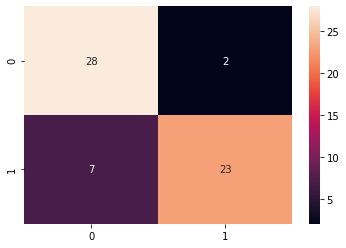

In [59]:
# {'Covid': 0, 'Normal': 1}
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

The 6-layered model did significantly better than the 5-layered model, with f1-scores higher across the board. However, the only issue is this model does contain false positives.

# HyperParameter Tuning

Below is a dictionary containing all the hyperparamters I would like to train. Unfortunately because I'm using generators to handle my data, I instead have to use my own way to cross check these hyperparamters. So, I've compiled all the combinations into a list and I use a function to create the 3-layer keras model using those hyperparamters and storying the results. From here I'll select the best model off a combination of loss and accuracy.

In [80]:
# what I would use if I could use GridSearchCV
param_grid = {
    'optimizer' : ['adam', 'sgd', 'rmsprop'],
    'activation' : ['relu', 'tanh'],
    'epochs' : [5, 10, 15],
    'epoch_steps' : [8, 16, 32]
}

# making a list of all combinations to try
all_params = sorted(param_grid)
param_lists = list(it.product(*(param_grid[param] for param in all_params)))
print(param_lists)

[('relu', 8, 5, 'adam'), ('relu', 8, 5, 'sgd'), ('relu', 8, 5, 'rmsprop'), ('relu', 8, 10, 'adam'), ('relu', 8, 10, 'sgd'), ('relu', 8, 10, 'rmsprop'), ('relu', 8, 15, 'adam'), ('relu', 8, 15, 'sgd'), ('relu', 8, 15, 'rmsprop'), ('relu', 16, 5, 'adam'), ('relu', 16, 5, 'sgd'), ('relu', 16, 5, 'rmsprop'), ('relu', 16, 10, 'adam'), ('relu', 16, 10, 'sgd'), ('relu', 16, 10, 'rmsprop'), ('relu', 16, 15, 'adam'), ('relu', 16, 15, 'sgd'), ('relu', 16, 15, 'rmsprop'), ('relu', 32, 5, 'adam'), ('relu', 32, 5, 'sgd'), ('relu', 32, 5, 'rmsprop'), ('relu', 32, 10, 'adam'), ('relu', 32, 10, 'sgd'), ('relu', 32, 10, 'rmsprop'), ('relu', 32, 15, 'adam'), ('relu', 32, 15, 'sgd'), ('relu', 32, 15, 'rmsprop'), ('tanh', 8, 5, 'adam'), ('tanh', 8, 5, 'sgd'), ('tanh', 8, 5, 'rmsprop'), ('tanh', 8, 10, 'adam'), ('tanh', 8, 10, 'sgd'), ('tanh', 8, 10, 'rmsprop'), ('tanh', 8, 15, 'adam'), ('tanh', 8, 15, 'sgd'), ('tanh', 8, 15, 'rmsprop'), ('tanh', 16, 5, 'adam'), ('tanh', 16, 5, 'sgd'), ('tanh', 16, 5, 'rms

In [90]:
def create_keras_model(activation, epochs, epoch_steps, optimizer):
    # model creation
    model = Sequential()

    # input layer
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # hidden layer 1
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # hidden layer 2
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation(activation))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    model_result = model.fit_generator(
        train_generator,
        steps_per_epoch=epoch_steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=2,
        verbose=0)
    
    return model_result

In [145]:
all_model_results = pd.DataFrame(columns=['params', 'val_loss', 'val_accuracy', 'loss', 'accuracy'])

#
for param_list in param_lists:
    model_results = create_keras_model(param_list[0], param_list[1], param_list[2], param_list[3])
    new_entry = pd.Series([param_list] + (list(pd.DataFrame(model_results.history).iloc[-1])), index=['params', 'val_loss', 'val_accuracy', 'loss', 'accuracy'])
    new_entry = new_entry.to_frame().T
    all_model_results = all_model_results.append(new_entry)

In [17]:
# all_model_results.sort_values(["accuracy", "loss"], ascending=False) 
# the output of this value took 4 hours to compile, unfortunately I lost the table, but here it exists in jpg
# data/display_images/hyperparameter_table.PNG

(relu, 32, 15, adam) will be the chosen hyperparameters for the model as they provided the higest accuracy and extremely low loss.

In [7]:
# model creation
final_model = Sequential()

# input layer
final_model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 1
final_model.add(Conv2D(32, (3, 3)))
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))

# hidden layer 2
final_model.add(Conv2D(64, (3, 3)))
final_model.add(Activation('relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))

final_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
final_model.add(Dense(64))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(1))
final_model.add(Activation('sigmoid'))

final_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

final_model_result = final_model.fit_generator(
    train_generator,
    steps_per_epoch=15,
    epochs=32,
    validation_data=validation_generator,
    validation_steps=2,
    verbose=1)

Epoch 1/32
15/15 [==============================] - 22s 1s/step - loss: 0.5068 - accuracy: 0.7315 - val_loss: 0.1976 - val_accuracy: 0.9667
Epoch 2/32
15/15 [==============================] - 21s 1s/step - loss: 0.2700 - accuracy: 0.9028 - val_loss: 0.0657 - val_accuracy: 0.9500
Epoch 3/32
15/15 [==============================] - 22s 1s/step - loss: 0.1450 - accuracy: 0.9560 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 4/32
15/15 [==============================] - 22s 1s/step - loss: 0.1393 - accuracy: 0.9649 - val_loss: 0.0258 - val_accuracy: 1.0000
Epoch 5/32
15/15 [==============================] - 22s 1s/step - loss: 0.0982 - accuracy: 0.9699 - val_loss: 0.0061 - val_accuracy: 0.9833
Epoch 6/32
15/15 [==============================] - 20s 1s/step - loss: 0.1219 - accuracy: 0.9534 - val_loss: 0.1040 - val_accuracy: 0.9333
Epoch 7/32
15/15 [==============================] - 22s 1s/step - loss: 0.1312 - accuracy: 0.9474 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 8/32
15/15 [==

In [9]:
pd.DataFrame(final_model_result.history)

,val_loss,val_accuracy,loss,accuracy
0,0.197558,0.966667,0.516078,0.731481
1,0.065742,0.950000,0.273052,0.902778
2,0.013660,1.000000,0.154168,0.956019
3,0.025809,1.000000,0.141248,0.964912
4,0.006148,0.983333,0.096506,0.969907
5,0.103996,0.933333,0.126376,0.953431
6,0.030131,1.000000,0.137095,0.947368
7,0.007207,1.000000,0.116563,0.958333
8,0.001385,1.000000,0.060174,0.983796
9,0.239303,0.950000,0.084459,0.971491


In [10]:
y_pred = []

# get predictions for all in the Normal validation set
for file in os.listdir("./data/prepped_datasets/val/Normal/"):
    img=image.load_img("./data/prepped_datasets/val/Normal/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    pred=final_model.predict_classes(img)
    y_pred.append(pred[0,0])
    
for file in os.listdir("./data/prepped_datasets/val/Covid/"):
    img=image.load_img("./data/prepped_datasets/val/Covid/" + file, target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    pred=final_model.predict_classes(img)
    y_pred.append(pred[0,0])
    
y_pred=np.array(y_pred)

In [11]:
confusion_matrix(y_true, y_pred)

array([[30,  0],
       [ 0, 30]], dtype=int64)

In [12]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



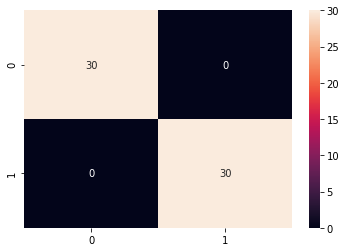

In [13]:
# {'Covid': 0, 'Normal': 1}
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)